In [1]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import math
import random

In [2]:
## Settings
d = 1 # of dimensions
M = 2 # of registers (rough estimate for M is the number of particles in the final state)
n = 1 # of particles in the initial state
N_abs = 3 # of modes for momenta
m = 1 # mass of particles of projectile
delta = 0.1

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.

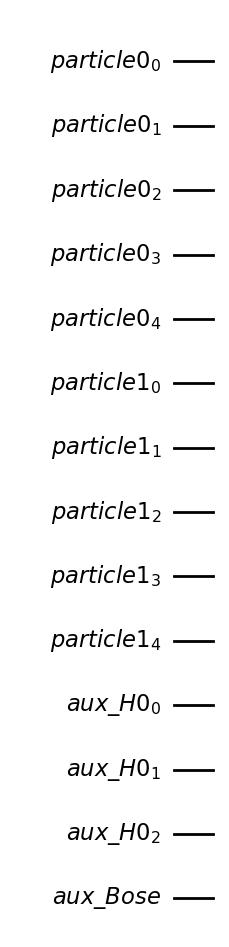

In [3]:
def init(M, N_abs, N): # initialize circuit
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister(N_abs, name = f'aux_H0') # aux registers for free Hamiltonian
    ancilla_register_symm = AncillaRegister(s, name = f'aux_Bose') # aux registers for Bose symmetrization
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm)
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm

circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, N)
circuit.draw('mpl')

In [4]:
#### examples of operation ####
## operate x gate to one certain qubit
# circuit.x(((L + 1) * d + 1) * M)
# circuit.h(particle_registers[0])
# circuit.h(particle_registers[0])
# circuit.h(ancilla_register_h0[1])

## operate x gate to one certain particle register
# circuit.x(particle_registers[0])

## operate x gate to all qubits
# for i in range(M):
#     circuit.x(particle_registers[i])

# circuit.draw('mpl') # 1つのparticleに対して下位 L* d ビットが運動量の大きさ、次のdビットが符号、最後1ビットがoccupancy

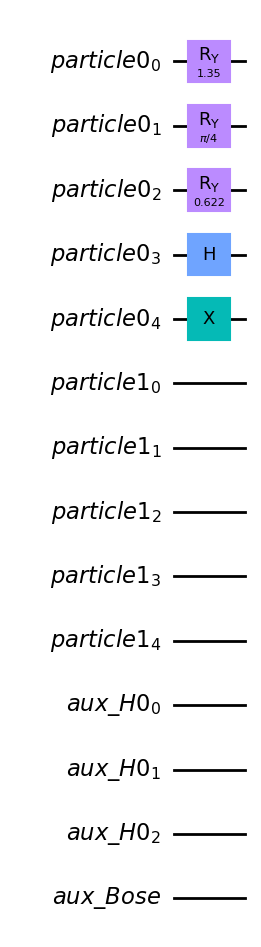

In [5]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, N)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
reg_list = [0]
for ireg in range(len(reg_list)):
    circuit.x(particle_regs[reg_list[ireg]][N_abs * d + d])
    circuit.h(particle_regs[reg_list[ireg]][N_abs * d : N_abs * d + d])
    for jqubit in range(N_abs * d):
        eps = random.uniform(0, np.pi / 4)
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * jqubit # 論文のAppendixのtheta_linear
        circuit.ry(2 * theta_lin, particle_regs[ireg][jqubit])
circuit.draw('mpl')

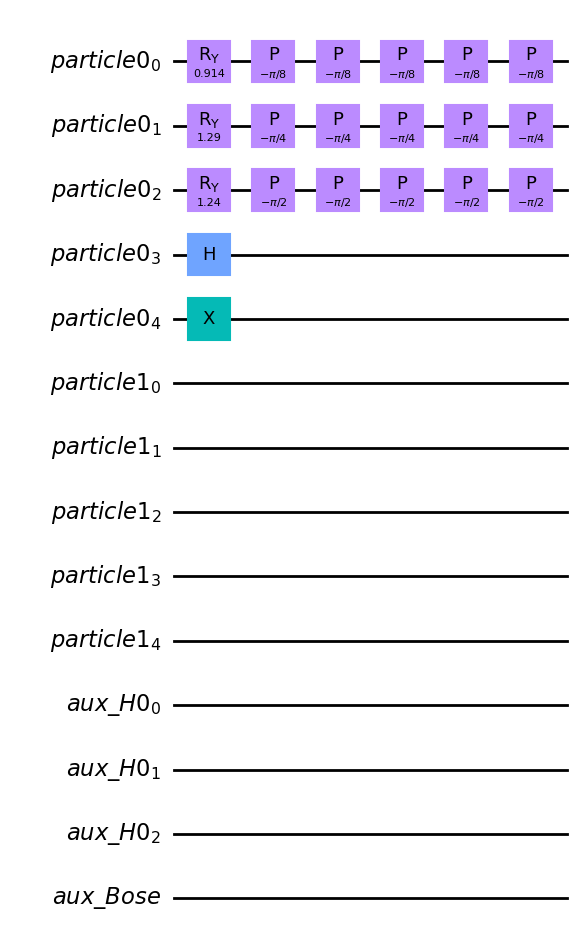

In [185]:
trans_mat = np.zeros((len(reg_list), d))
trans_mat[0][0] = 5 # 第0量子レジスタの第0次元に存在する粒子を5マス移動

# check whether constraint is satisfied
for icolumn in range(len(trans_mat)):
    for jrow in range(len(trans_mat[0])):
        if trans_mat[icolumn][jrow] > N_s: # N_s - 1 かも？
            print('Constraint Error!!')

for ireg in range(len(reg_list)): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for jqubit in range(N_abs): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if trans_mat[ireg][idim] > 0:
                    circuit.p((-2. * np.pi * (2. ** jqubit)) / N_s, particle_regs[ireg][jqubit])
                elif trans_mat[ireg][idim] < 0:
                    circuit.p((2. * np.pi * (2. ** jqubit)) / N_s, particle_regs[ireg][jqubit])

circuit.draw('mpl')

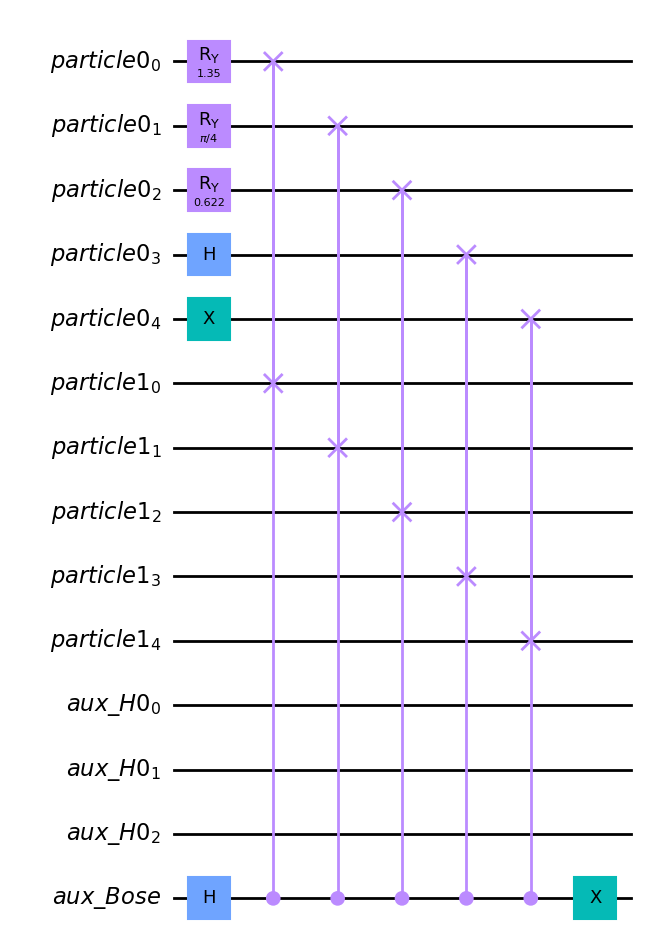

In [6]:
## symmetrization
circuit.h(anc_reg_symm[0])
for ireg in range(M):
    for jreg in range(M):
        for iqubit in range(N):
            if ireg > jreg:
                circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
circuit.x(anc_reg_symm[0])

circuit.draw('mpl')

In [ ]:
#### B. Time Evolution ####
## Free Hamiltonian ##
# 全体位相がかかるだけなので要らないのでは？

## Squeezing transformation

In [84]:
def additiveGate(particle_regs, anc_reg_h0):
    circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    circuit.h(anc_reg_h0)
    dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
    for reg_ctrl in particle_regs: # reg_ctrl is QuantumRegister
        for ictrl, qctrl in enumerate(reg_ctrl): # ictrl is number, qctrl is qubit
            for itarg, qtarg in enumerate(anc_reg_h0): # itarg is number, qtarg is ancilla qubit
                circuit.cp(dphi ** (2 ** (ictrl + itarg)), qctrl, qtarg)
    circuit.h(anc_reg_h0)
    return circuit

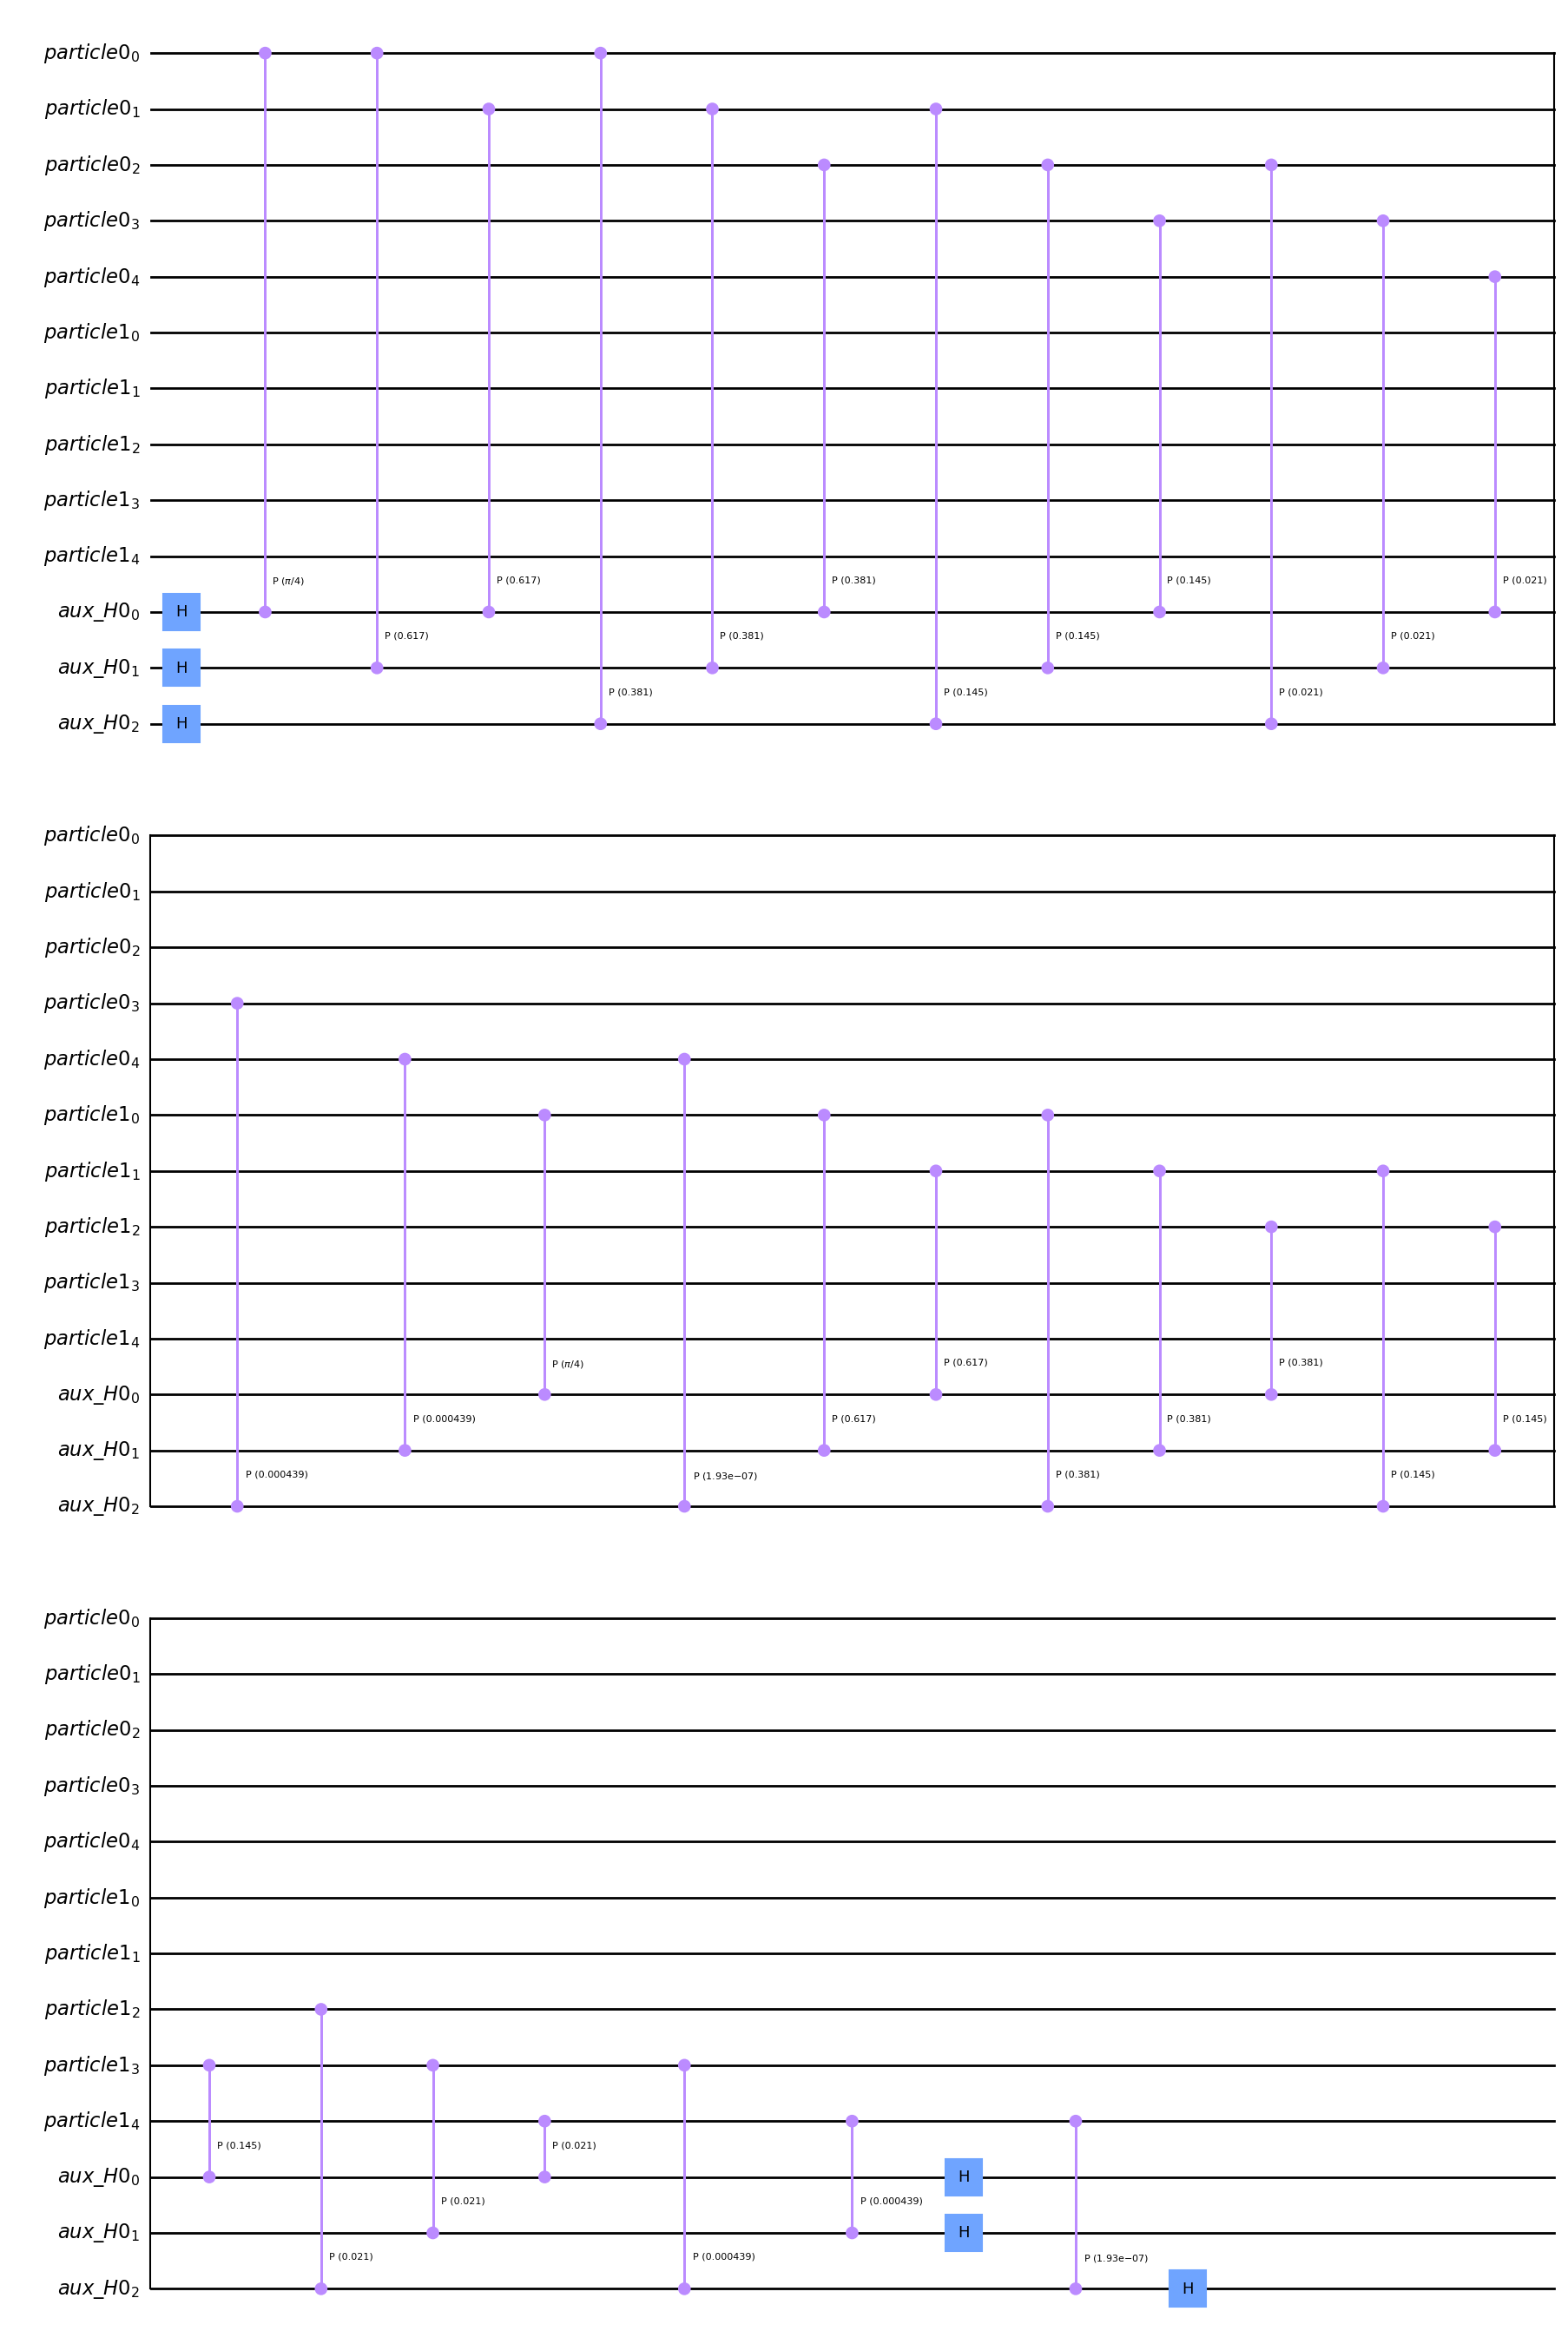

In [85]:
test_circuit=additiveGate(particle_regs, anc_reg_h0)
test_circuit.draw('mpl')

In [20]:
def addition(circuit, reg_in_list, reg_out): # reg_in is the list of registers, reg_out is qubits
    circuit.h(reg_out)
    dphi = 2. * np.pi / (2 ** reg_out.size)
    # print(reg_in_list)
    for reg_ctrl in reg_in_list: # reg_ctrl corresponds to QuantumRegister, reg_in_list to list of QuantumRegister
        for ictrl, qctrl in enumerate(reg_ctrl): # qctrl corresponds to Qubits, reg_ctrl to QuantumRegister
            for itarg, qtarg in enumerate(reg_out): # qtarg corresponds to Qubits, reg_out to QuantumRegister
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    circuit.h(reg_out)
    return circuit

In [21]:
def make_add_gate(M, L): # M \times L bits に対して L bitsの補助ビットを使って足し算するゲート
    reg_list = []
    for _ in range(M + 1):
        reg_list.append(QuantumRegister(L))
    circuit = QuantumCircuit(*reg_list)
    add_circuit = addition(circuit, reg_list[0:M], reg_list[M])
    add_gate = add_circuit.to_gate()
    cadd_gate = add_gate.control(1) # controlled add_gate
    return add_gate, cadd_gate

In [22]:
def set_target_list(M, L, particle_registers):
    targ_list = []
    for i in range(M+1):
        targ_list += particle_registers[i][0:L]
    return targ_list

In [23]:
# def symmetrization(circuit, particle_registers, M):
#     aux = QuantumRegister(M)
#     circuit.h(aux)
#     for i in range(N):
#         if i != 0:
#             circuit.cswap(particle_registers[i - 1], particle_registers[i], aux(i))
#         else: circuit.swap(particle_registers[M - 1], particle_registers[0], aux(i))
#     sym_gate = circuit.to_gate()
#     return sym_gate

In [52]:
## main
circuit, particle_registers = init(M) # initialization

circuit.x(particle_registers[0][0]) # make arbitrary circuit

add_gate, cadd_gate = make_add_gate(M, L) # make addition gate
targ_list = set_target_list(M, L, particle_registers) # set target_list

circuit.append(add_gate, qargs=targ_list)
for i in range(M):
    circuit.barrier()
    circuit.x(particle_registers[i][L + d])
    circuit.append(cadd_gate, qargs=([particle_registers[i][L + d]] + targ_list)) # n_Omega times
    circuit.x(particle_registers[i][L + d])

circuit.draw('mpl')

ValueError: too many values to unpack (expected 2)

In [31]:
# particle_registers[0:2] # QuantumRegisterのリスト [QuantumRegister(4, 'particle0'), QuantumRegister(4, 'particle1')]
# particle_registers[:2][1] # QuantumRegister # リストの第１成分 QuantumRegister(4, 'particle1')
# particle_registers[:2][1][0:2] # Qubitのリスト
# particle_registers[:2][1][0] # Qubit # Qubit(QuantumRegister(4, 'particle1'), 0)

Qubit(QuantumRegister(4, 'particle1'), 0)

In [ ]:
## Settings for translation
n_i = [5] # position labels ex) n_i[0]=5 means 1st dimenstion center position

In [ ]:
## how to measure and count
# circuit.measure_all()
# # Run the circuit in qasm_simulator and plot the histogram
# simulator = AerSimulator()
# circuit = transpile(circuit, backend=simulator)
# job = simulator.run(circuit, shots=10000)
# result = job.result()
# counts = result.get_counts(circuit)
# plot_histogram(counts)